Dropdown(description='Select Plot:', options=('S&P 500 - Line Chart', 'VIX - Line Chart', 'Gold - Line Chart',…

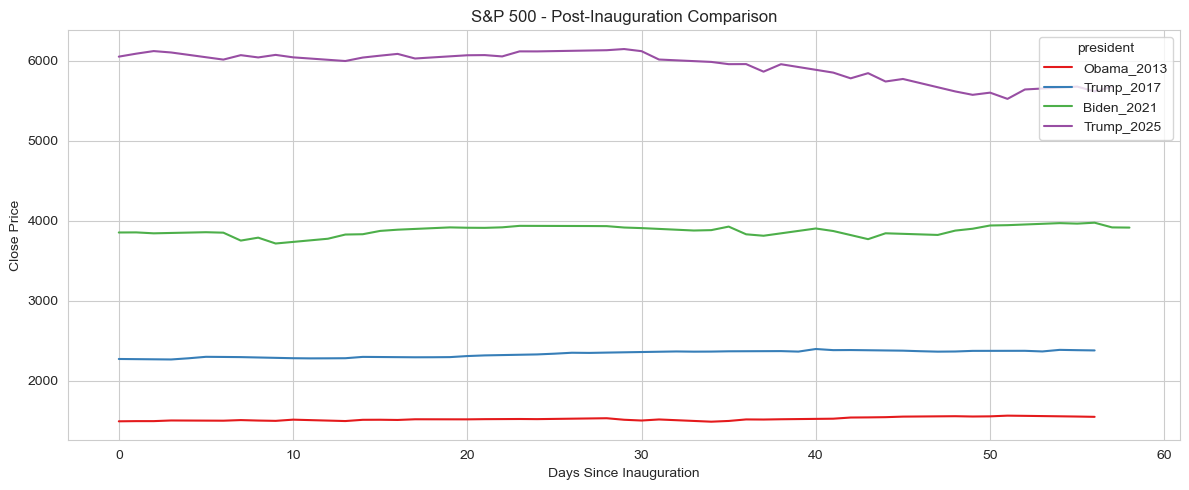

In [2]:
# Import dependencies
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Set style for plots
sns.set_style("whitegrid")

# Connect to the SQLite database
conn = sqlite3.connect("market_data.db")

# Define 2-month windows after each inauguration
inaugurations = {
    "Obama_2013": ("2013-01-20", "2013-03-20"),
    "Trump_2017": ("2017-01-20", "2017-03-20"),
    "Biden_2021": ("2021-01-20", "2021-03-20"),
    "Trump_2025": ("2025-01-20", "2025-03-20")
}

# Reusable function to get clean data for any asset table
def get_inauguration_window_data(table_name, selected_presidents):
    all_data = []
    for pres, (start, end) in inaugurations.items():
        if pres not in selected_presidents:
            continue
        query = f"""
        SELECT date, close
        FROM {table_name}
        WHERE date BETWEEN '{start}' AND '{end}'
        ORDER BY date
        """
        df = pd.read_sql(query, conn)
        df["date"] = pd.to_datetime(df["date"])
        df["president"] = pres
        df["day_number"] = (df["date"] - df["date"].min()).dt.days
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Reusable plot function for line chart
def plot_inauguration_comparison(df, title, color_palette="Set1"):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="day_number", y="close", hue="president", palette=color_palette)
    plt.title(title)
    plt.xlabel("Days Since Inauguration")
    plt.ylabel("Close Price")
    plt.tight_layout()
    plt.show()

# Function to calculate percent change for each asset
def calculate_percent_change(table_name):
    results = []
    for pres, (start, end) in inaugurations.items():
        query = f"""
        SELECT date, close
        FROM {table_name}
        WHERE date BETWEEN '{start}' AND '{end}'
        ORDER BY date
        """
        df = pd.read_sql(query, conn)
        df["date"] = pd.to_datetime(df["date"])
        df.dropna(subset=["close"], inplace=True)
        if len(df) > 1:
            first = df["close"].iloc[0]
            last = df["close"].iloc[-1]
            change = ((last - first) / first) * 100
            results.append({"president": pres, "percent_change": round(change, 2)})
        else:
            results.append({"president": pres, "percent_change": None})
    return pd.DataFrame(results)

# Run percent change for each asset
assets = {
    "S&P 500": "sp500",
    "VIX": "vix",
    "Gold": "gold",
    "Crude Oil": "oil"
}

summary_df = pd.DataFrame()

for asset_name, table in assets.items():
    df = calculate_percent_change(table)
    df.rename(columns={"percent_change": asset_name}, inplace=True)
    if summary_df.empty:
        summary_df = df
    else:
        summary_df = pd.merge(summary_df, df, on="president")

summary_df.set_index("president", inplace=True)

# Function to plot the bar chart of percent change grouped by president
def plot_bar_chart_percent_change():
    summary_df_plot = summary_df.reset_index().melt(id_vars="president", var_name="Asset", value_name="Percent Change")
    plt.figure(figsize=(12, 6))
    sns.barplot(data=summary_df_plot, x="president", y="Percent Change", hue="Asset")
    plt.title("2-Month % Change Post-Inauguration by President")
    plt.xlabel("President")
    plt.ylabel("Percent Change (%)")
    plt.axhline(0, color="gray", linestyle="--")
    plt.legend(title="Asset")
    plt.tight_layout()
    plt.show()

# Run percent change for tech stocks
tech_stocks = {
    "AAPL": "aapl",
    "AMZN": "amzn",
    "MSFT": "msft",
    "NVDA": "nvda",
    "GOOGL": "googl"
}

tech_df = pd.DataFrame()

for stock_name, table in tech_stocks.items():
    df = calculate_percent_change(table)
    df.rename(columns={"percent_change": stock_name}, inplace=True)
    if tech_df.empty:
        tech_df = df
    else:
        tech_df = pd.merge(tech_df, df, on="president")

tech_df.set_index("president", inplace=True)

# Function to plot bar chart for a single stock
def plot_stock_percent_change(df, stock_name):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df,
        x="president",
        y=stock_name,
        palette="Set1"
    )
    plt.title(f"{stock_name} - 2-Month % Change Post-Inauguration", fontsize=14)
    plt.ylabel("Percent Change (%)")
    plt.xlabel("President")
    plt.axhline(0, color="gray", linestyle="--")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to plot heatmap for tech stocks
def plot_tech_heatmap():
    plt.figure(figsize=(10, 5))
    sns.heatmap(tech_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
    plt.title("Tech Stock 2-Month % Change by President (Heatmap)")
    plt.xlabel("Stock")
    plt.ylabel("President")
    plt.tight_layout()
    plt.show()

# Dropdown for selecting the type of plot to display
plot_dropdown = widgets.Dropdown(
    options=[
        'S&P 500 - Line Chart',
        'VIX - Line Chart',
        'Gold - Line Chart',
        'Crude Oil - Line Chart',
        '2-Month % Change Post-Inauguration (Bar Chart)',
        'Tech Stock % Change (Bar Charts)',
        'Tech Stock % Change Heatmap'
    ],
    description='Select Plot:',
    value='S&P 500 - Line Chart'  # Set default selection to S&P 500 chart
)

# Function to display the selected plot
def display_selected_plot(change):
    selected_plot = plot_dropdown.value
    if selected_plot == 'S&P 500 - Line Chart':
        df_sp500 = get_inauguration_window_data("sp500", selected_presidents=["Obama_2013", "Trump_2017", "Biden_2021", "Trump_2025"])
        plot_inauguration_comparison(df_sp500, "S&P 500 - Post-Inauguration Comparison")
    elif selected_plot == 'VIX - Line Chart':
        df_vix = get_inauguration_window_data("vix", selected_presidents=["Obama_2013", "Trump_2017", "Biden_2021", "Trump_2025"])
        plot_inauguration_comparison(df_vix, "VIX - Post-Inauguration Comparison")
    elif selected_plot == 'Gold - Line Chart':
        df_gold = get_inauguration_window_data("gold", selected_presidents=["Obama_2013", "Trump_2017", "Biden_2021", "Trump_2025"])
        plot_inauguration_comparison(df_gold, "Gold - Post-Inauguration Comparison")
    elif selected_plot == 'Crude Oil - Line Chart':
        df_oil = get_inauguration_window_data("oil", selected_presidents=["Obama_2013", "Trump_2017", "Biden_2021", "Trump_2025"])
        plot_inauguration_comparison(df_oil, "Crude Oil - Post-Inauguration Comparison")
    elif selected_plot == '2-Month % Change Post-Inauguration (Bar Chart)':
        plot_bar_chart_percent_change()
    elif selected_plot == 'Tech Stock % Change (Bar Charts)':
        for stock in tech_df.columns:
            if stock != 'president':
                plot_stock_percent_change(tech_df, stock)
    elif selected_plot == 'Tech Stock % Change Heatmap':
        plot_tech_heatmap()

# Set up the interactive widget
plot_dropdown.observe(display_selected_plot, names='value')

# Display the dropdown for user interaction
display(plot_dropdown)

# Initial plot display (simulating "init" behavior) by calling the function once to show default plot
display_selected_plot({'new': 'S&P 500 - Line Chart'})
